In [1]:
!pip install opencv-python
!pip install tensorflow

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
%matplotlib inline
from sklearn import metrics
import sklearn.metrics
from sklearn.metrics import DistanceMetric
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
confusion_matrix, ConfusionMatrixDisplay,
plot_roc_curve,roc_auc_score)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preprocessing

In [3]:
img_train = r'Emergency_Vehicles\train'
img_test = r'Emergency_Vehicles\test'

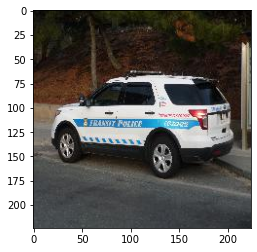

In [4]:
image = cv2.imread(r'Emergency_Vehicles\train\1.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [5]:
image.shape # This shows the shape of the image (length, width,chanel)

(224, 224, 3)

In [6]:
from keras.preprocessing.image import ImageDataGenerator # Keras image data generator is used for the generation

In [7]:
# Here we are applying our desired transformations 
image_gen = ImageDataGenerator(
 rotation_range=20,# specifies the rotation to be 20%
 width_shift_range=0.1, # specifies the width shift of 10%
 height_shift_range=0.1,# specifies the height shift of 10%
 shear_range=0.20, # crops part of the image 
 zoom_range=0.20, # #zooms the image by 20%
 fill_mode='nearest', # fills using the nearest pixel 
 horizontal_flip=True, # Secifies the horizontal flip 
 rescale=1/255 # scales the image 
)

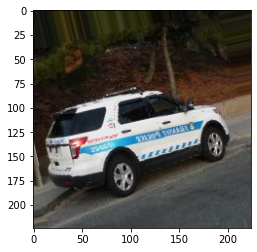

In [8]:
# showing the transformation
plt.imshow(image_gen.random_transform(image))

In [9]:
train_df=pd.read_csv(r'Emergency_Vehicles\train.csv')
test_df=pd.read_csv(r'Emergency_Vehicles\test.csv')

In [10]:
train_df

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0
...,...,...
1641,1638.jpg,0
1642,1095.jpg,0
1643,1130.jpg,0
1644,1294.jpg,0


In [11]:
test_df

,image_names,emergency_or_not
0,100.jpg,1
1,1000.jpg,0
2,1001.jpg,0
3,1004.jpg,0
4,1014.jpg,0
...,...,...
701,981.jpg,1
702,986.jpg,1
703,99.jpg,1
704,990.jpg,1


In [12]:
# labels to string
train_df['emergency_or_not'] = train_df['emergency_or_not'].astype(str)
test_df['emergency_or_not'] = test_df['emergency_or_not'].astype(str)

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   image_names       1646 non-null   object
 1   emergency_or_not  1646 non-null   object
dtypes: object(2)
memory usage: 25.8+ KB


In [14]:
train_generator=image_gen.flow_from_dataframe(dataframe=train_df[:1200], # specify the dataset used for training
                                             directory=img_train, # specify the path to the directory
                                             x_col='image_names', # specify the names of the images
                                             y_col='emergency_or_not', # specifies the class labels
                                             class_mode='binary', # specifies the kind of classification
                                             target_size=(224,224), # specifies the dimension to resize the image
                                             batch_size=50 # defines the batch size 
                                             )
validation_generator=image_gen.flow_from_dataframe(dataframe=train_df[1200:], # specify the dataset used for tr
                                                 directory=img_train, # specify the path to the directory
                                                 x_col='image_names', # specify the names of the images
                                                 y_col='emergency_or_not', # specifies the class labels
                                                 class_mode='binary', # specifies the kind of classification
                                                 target_size=(224,224), # specifies the dimension to resize the im
                                                 batch_size=50 # defines the batch size 
                                                 )

Found 1200 validated image filenames belonging to 2 classes.
Found 446 validated image filenames belonging to 2 classes.


In [15]:
from keras.models import Sequential
from keras.layers import Activation,Dropout,Conv2D,MaxPooling2D,Flatten,Dense,BatchNormalization

In [16]:
model = Sequential()
model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(224,224,3),activation = 'relu',padding = 'same'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(224,224,3),activation = 'relu', padding = 'valid'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(224,224,3),activation = 'relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(50,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation = 'sigmoid'))

In [17]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 flatten (Flatten)           (None, 1605632)           0         
                                                                 
 dense (Dense)               (None, 50)                80281650  
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 80,282,597
Trainable params: 80,282,597
Non-trainable params: 0
_________________________________________________________________


In [19]:
history=model.fit_generator(train_generator,epochs = 10,validation_data = validation_generator)

C:\Users\ekegr\AppData\Local\Temp\ipykernel_47476\2704492499.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator,epochs = 10,validation_data = validation_generator)


Epoch 1/10
24/24 [==============================] - 98s 4s/step - loss: 28.6941 - accuracy: 0.5025 - val_loss: 2.6679 - val_accuracy: 0.6345
Epoch 2/10
24/24 [==============================] - 83s 3s/step - loss: 1.1938 - accuracy: 0.5450 - val_loss: 0.6532 - val_accuracy: 0.6771
Epoch 3/10
24/24 [==============================] - 84s 4s/step - loss: 0.6265 - accuracy: 0.6833 - val_loss: 0.5639 - val_accuracy: 0.7646
Epoch 4/10
24/24 [==============================] - 86s 4s/step - loss: 0.5725 - accuracy: 0.7317 - val_loss: 0.5157 - val_accuracy: 0.7646
Epoch 5/10
24/24 [==============================] - 89s 4s/step - loss: 0.5404 - accuracy: 0.7483 - val_loss: 0.4874 - val_accuracy: 0.7825
Epoch 6/10
24/24 [==============================] - 82s 3s/step - loss: 0.5145 - accuracy: 0.7617 - val_loss: 0.5377 - val_accuracy: 0.7422
Epoch 7/10
24/24 [==============================] - 82s 3s/step - loss: 0.5217 - accuracy: 0.7433 - val_loss: 0.4318 - val_accuracy: 0.7915
Epoch 8/10
24/24 [=

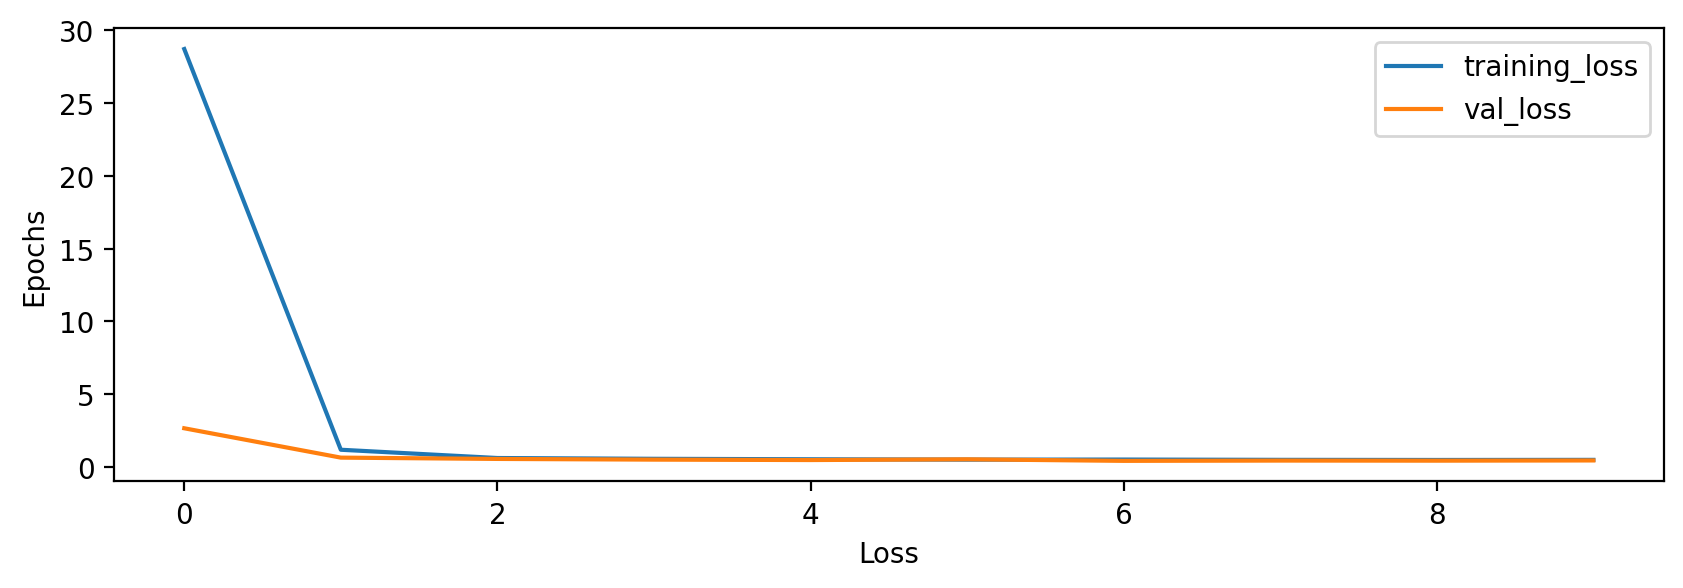

In [20]:
## checking for overfitting 
history_df = pd.DataFrame(history.history)
plt.figure(dpi=200, figsize = (10,3))
plt.plot(history_df['loss'],
 label='training_loss')
plt.plot(history_df['val_loss'],
 label='val_loss')
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.legend()
plt.show()

In [21]:
test_generator=image_gen.flow_from_dataframe(dataframe=test_df, # specify the dataset used for training
                                             directory=img_test, # specify the path to the directory
                                             x_col='image_names', # specify the names of the images
                                             y_col='emergency_or_not', # specifies the class labels
                                             class_mode='binary', # specifies the kind of classification
                                             target_size=(224,224), # specifies the dimension to resize the im
                                             batch_size=706 # defines the batch size 

                                             )

Found 706 validated image filenames belonging to 2 classes.


## Modeling

In [22]:
# make predictions using model 1
preds = model.predict(test_generator[0][0])

23/23 [==============================] - 7s 272ms/step


In [23]:
#  convert
preds = [0 if x[0] < 0.5 else 1 for x in preds]

In [24]:
# true labels
true_labels = test_generator[0][1]

In [25]:
#  derive classification report
print(classification_report(true_labels, preds))

              precision    recall  f1-score   support

         0.0       0.76      0.89      0.82       410
         1.0       0.80      0.62      0.70       296

    accuracy                           0.77       706
   macro avg       0.78      0.75      0.76       706
weighted avg       0.78      0.77      0.77       706



Text(0.5, 1.0, 'Confusion Matrix for MODEL_1')

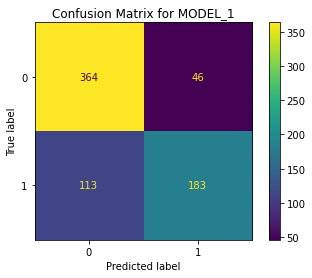

In [26]:
cm = confusion_matrix(true_labels, preds)

ax = ConfusionMatrixDisplay(cm)

ax.plot()

plt.title('Confusion Matrix for the MODEL')

In [32]:
model.evaluate(test_generator)
#pred=model.predict(test_generator) # assigning the prediction to a variable for further evaluation

1/1 [==============================] - 56s 56s/step - loss: 0.4762 - accuracy: 0.7734


[0.4762432873249054, 0.7733711004257202]

In [33]:
train_df.isnull().sum()

image_names         0
emergency_or_not    0
dtype: int64